In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [ ]:
import os

data_dir = os.environ.get("DATA_DIR", "datasets/dataset/")
print(f"Using data directory: {data_dir}")

train = pd.read_csv(data_dir + 'train_with_aqi.csv')
test = pd.read_csv(data_dir + 'test_with_aqi.csv')
feature_cols = [
    "temp", 
    "humidity", 
    "precip",
    "overall_AQI"
]

class WeatherDataset(Dataset):
    def __init__(self, df, features, target, window_size=10, step_size=1, steps_ahead=1):
        df = df.fillna(0)
        self.date = df['datetime'].values
        self.features = df[features].values
        self.ori_features = self.features
        self.window_size = window_size
        self.step_size = step_size
        self.steps_ahead = steps_ahead
        self.target = df[target].values
        self.normalize()
        self.construct_sequences(window_size, step_size, steps_ahead)
    
    
    def normalize(self):
        self.feat_mean = np.mean(self.features, axis=0)
        self.feat_std = np.std(self.features, axis=0)
        self.target_mean = np.mean(self.target, axis=0)
        self.target_std = np.std(self.target, axis=0)
        self.features = (self.features - self.feat_mean) / self.feat_std
        self.target = (self.target - self.target_mean) / self.target_std
        
    
        
        
    def construct_sequences(self, window_size, step_size, steps_ahead):
        features = []
        target = []
        for i in range(0, len(self.features) - window_size - steps_ahead + 1, step_size):
            features.append(self.features[i:i+window_size])
            target.append(self.target[i+window_size:i+window_size+steps_ahead])
        self.features = np.array(features)
        self.target = np.array(target)
        

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx], self.date[idx+self.window_size] 
    
    
def collate_fn(batch):
    features = []
    target = []
    target_date = []
    for f, t, d in batch:
        features.append(f)
        target.append(t)
        target_date.append(d)
    return torch.tensor(features, dtype=torch.float32), torch.tensor(target, dtype=torch.float32), target_date

In [24]:
train_data = WeatherDataset(train, feature_cols, feature_cols, window_size=3)
test_data = WeatherDataset(test, feature_cols, feature_cols, window_size=3)

AttributeError: 'function' object has no attribute 'fillna'

In [30]:


class WeatherModel(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, output_size=4, num_layers=4, dropout=0.1):
        super(WeatherModel, self).__init__()
                
        # Replaced GRU with LSTM
        #self.RNN_Encoder = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        #ADDED DROPOUT
        self.RNN_Encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )
        
        
    def forward(self, x):
        # print(x.shape)
        out, hs = self.RNN_Encoder(x)
        out = self.fc(out) # B, L, D
        return out    
        
# Test
model = WeatherModel()
features, target,_ = train_data[0] # t0, t1, t2
features = torch.tensor(features, dtype=torch.float32).unsqueeze(0)
target = torch.tensor(target, dtype=torch.float32).unsqueeze(0) # t3
output = model(features) # t1, t2, t3
target = torch.cat([features[:, 1:], target], dim=1)
print(output.shape, target.shape)

torch.Size([1, 3, 4]) torch.Size([1, 3, 4])


In [31]:
def train(model, criterion, optimizer, train_loader, epochs=30, device='cpu'):
    #No. of Ephocs changed to 30 for LSTM
    best_loss = np.inf
    best_model = None
    for epoch in range(epochs):
        model.train()
        loss_history = []
        for i, (features, target, _) in enumerate(train_loader):
            features = features.to(device, dtype=torch.float32)
            target = target.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            output = model(features)
            target_seq = torch.cat([features[:, 1:], target], dim=1)
            
            loss = criterion(output, target_seq)
            loss.backward()

            #clips exploding LSTM gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            loss_history.append(loss.item())
            
        epoch_loss = np.mean(loss_history)
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            # save the best model
            best_model = model.state_dict()
            torch.save(best_model, 'best_model.pth')
        print(f'Epoch {epoch} Loss: {epoch_loss}')
    return best_model
        
        
def test(model, criterion, test_loader, device='cpu'):
    model.eval()
    predictions = []
    with torch.no_grad():
        for idx, (features, target, date) in enumerate(test_loader):
            features = features.to(device,dtype=torch.float32)
            target = target.to(device, dtype=torch.float32)
            output = model(features)[:, -1, :]
            loss = criterion(output, target)       
            print(f'Test Loss: {loss.item()}')
            predictions.append({"date": date, "prediction": output.cpu().numpy()})
    return predictions

In [32]:
model = WeatherModel(input_size=4, hidden_size=64, output_size=4,num_layers=3, dropout=0.1)
criterion = nn.MSELoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
#lower LR + decoupled weight-decay lets the deeper LSTM converge without overshooting
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)




WeatherModel(
  (RNN_Encoder): LSTM(4, 64, num_layers=3, batch_first=True, dropout=0.1)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=4, bias=True)
  )
)

In [33]:
train_data[0]

(array([[-1.48807225, -1.35864164, -0.39762618, -1.69823911],
        [-1.0422029 , -1.28220408, -0.39762618,  1.34220701],
        [-1.42437663, -0.09742195,  1.39041992,  1.09568435]]),
 array([[-0.67740071,  1.96639208,  2.05738949, -0.71214848]]),
 '2015-01-04')

In [34]:
train(model, criterion, optimizer, train_loader, epochs=30, device=device)

Epoch 0 Loss: 0.8472489331799232
Epoch 1 Loss: 0.7045863038171006
Epoch 2 Loss: 0.6769302158977036
Epoch 3 Loss: 0.6630985418031382
Epoch 4 Loss: 0.6506290795171962
Epoch 5 Loss: 0.6293246633336254
Epoch 6 Loss: 0.6113575349387327
Epoch 7 Loss: 0.6062818004886038
Epoch 8 Loss: 0.6037023863290142
Epoch 9 Loss: 0.6002063544112909
Epoch 10 Loss: 0.5977402547560378
Epoch 11 Loss: 0.5954006004635188
Epoch 12 Loss: 0.5941181667607721
Epoch 13 Loss: 0.593624214059514
Epoch 14 Loss: 0.5914686059046704
Epoch 15 Loss: 0.5910622109588944
Epoch 16 Loss: 0.590491433680139
Epoch 17 Loss: 0.5884656886558689
Epoch 18 Loss: 0.5888865055202949
Epoch 19 Loss: 0.5867566423727615
Epoch 20 Loss: 0.5865273004965972
Epoch 21 Loss: 0.5859860660031785
Epoch 22 Loss: 0.5855760919860221
Epoch 23 Loss: 0.5835213410462955
Epoch 24 Loss: 0.5832870498442291
Epoch 25 Loss: 0.582574549150206
Epoch 26 Loss: 0.5815580555132085
Epoch 27 Loss: 0.5797923362613866
Epoch 28 Loss: 0.5796392627478298
Epoch 29 Loss: 0.5778915102

OrderedDict([('RNN_Encoder.weight_ih_l0',
              tensor([[ 0.0162, -0.1279, -0.4607,  0.0128],
                      [ 0.4074,  0.0894, -0.0669, -0.2980],
                      [-0.2109,  0.2822, -0.1986, -0.0922],
                      ...,
                      [-0.1946,  0.1142, -0.1671, -0.5986],
                      [-0.0648, -0.0833,  0.2378,  0.2745],
                      [-0.0774, -0.1161, -0.3888,  0.4374]])),
             ('RNN_Encoder.weight_hh_l0',
              tensor([[-0.1653,  0.1339, -0.0270,  ...,  0.2084, -0.0556,  0.0462],
                      [-0.0670,  0.0273, -0.1099,  ...,  0.1679, -0.1301, -0.0408],
                      [-0.1557,  0.0270,  0.1356,  ...,  0.2693, -0.3735, -0.2471],
                      ...,
                      [-0.1398,  0.0299, -0.0748,  ..., -0.0737, -0.0627, -0.0792],
                      [-0.1788,  0.1308,  0.1515,  ..., -0.0901, -0.0906, -0.0136],
                      [-0.0111,  0.1671, -0.0556,  ...,  0.1188, -0.1348,  0.27

In [35]:
test_data.target

array([[[-1.04433204, -0.50070938, -0.38811281, -0.08841384]],

       [[-1.64037763, -1.20307493, -0.38811281, -0.75645838]],

       [[-1.2262828 ,  0.15736285, -0.2272735 , -0.47015357]],

       ...,

       [[-0.07183661,  0.82176269,  1.26443226,  1.15224031]],

       [[-0.60514056,  0.04979335, -0.38811281, -2.95146186]],

       [[-0.54239892,  1.18876451,  1.57034231, -0.75645838]]])

/tmp/ipykernel_31/2872224328.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
/usr/local/lib/python3.11/dist-packages/

Test Loss: 0.19354885816574097
Test Loss: 0.3380761742591858
Test Loss: 0.20931462943553925
Test Loss: 2.4307992458343506
Test Loss: 0.2538560628890991
Test Loss: 0.9970068335533142
Test Loss: 10.006834983825684
Test Loss: 0.011648332700133324
Test Loss: 0.635260820388794
Test Loss: 3.8317484855651855
Test Loss: 0.22029894590377808
Test Loss: 0.26440486311912537
Test Loss: 1.942979335784912
Test Loss: 0.4320065379142761
Test Loss: 0.5199126601219177
Test Loss: 0.09374409914016724
Test Loss: 0.4576547145843506
Test Loss: 0.2193509042263031
Test Loss: 0.4152180254459381
Test Loss: 0.670480489730835
Test Loss: 0.9410728216171265
Test Loss: 0.7466956377029419
Test Loss: 2.2687277793884277
Test Loss: 0.6820175051689148
Test Loss: 0.8223140239715576
Test Loss: 0.2087603360414505
Test Loss: 0.1685468554496765
Test Loss: 0.23141418397426605
Test Loss: 0.13524660468101501
Test Loss: 0.2909676432609558
Test Loss: 0.5907596349716187
Test Loss: 0.17703039944171906
Test Loss: 0.5276362895965576
Tes

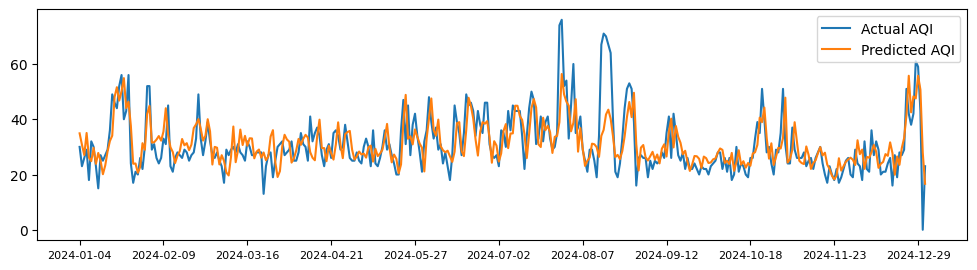

In [36]:
# Transforem the data back to the original scale
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
result = test(model, criterion, test_loader, device=device)

dates = [p['date'][0] for p in result]
result = [p['prediction'] for p in result]
result = np.concatenate(result, axis=0)


prediction = result * test_data.target_std + test_data.target_mean
target  = test_data.target * test_data.target_std + test_data.target_mean
target = target.squeeze()
result = result.squeeze()


plt.figure(figsize=(12, 3))
plt.plot(target[:, 3], label='Actual AQI')
plt.plot(prediction[:, 3], label='Predicted AQI')
plt.legend(loc='upper right')


plt.xticks(range(0, len(dates), len(dates) // 10), dates[::len(dates) // 10])
plt.tick_params(axis='x', labelsize=8)



plt.savefig('result.pdf')
plt.show()
# ax, fig = 
# fig.plot(prediction[:, -1], label='Predicted AQI')
# fig.plot(target[:, -1], label='Actual AQI')
# fig.legend(loc='upper right')


# axes, fig = plt.subplots(4, 1, figsize=(16, 6))
# fig[0].plot(prediction[:, 0], label='Predicted Temperature')
# fig[0].plot(target[:, 0], label='Actual Temperature')
# fig[0].legend(loc='upper right')
# # legend location

# fig[1].plot(prediction[:, 1], label='Predicted Humidity')
# fig[1].plot(target[:, 1], label='Actual Humidity')
# fig[1].legend(loc='upper right')
# fig[2].plot(prediction[:, 2], label='Predicted Precip')
# fig[2].plot(target[:, 2], label='Actual Precip')
# fig[2].legend(loc='upper right')

# fig[3].plot(prediction[:, 3], label='Predicted AQI')
# fig[3].plot(target[:, 3], label='Actual AQI')
# fig[3].legend(loc='upper right')


